# A larger CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv2D, MaxPooling2D, Dense, Conv1D, Dropout
from keras.layers import MaxPooling1D, Flatten, Embedding, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
import spacy
import nltk
import en_core_web_md

Using TensorFlow backend.


In [2]:
ign_df = pd.read_pickle('ign_data/ign_data_pass_three.pkl')

ign_df = ign_df.loc[ign_df['review_score']!='null']
ign_df.reset_index(drop=True)

print(ign_df.shape)
ign_df.head()

(11072, 19)


,links,rough_review_body,cleaned_review_body,review_summary_rough,review_score,tags,categories,modified_date,published_date,author_name,tag_list,categories_list,review_title,review_body_corpus,review_score_float,number_character_review,number_words_review,polarity,subjectivity
1,https://www.ign.com/articles/2011/07/19/warham...,"\u003csection class=\""article-page\""\u003e\u00...",'Warhammer 40K: Kill Team might be unfortun...,"""And \""also-ran\"" hangs all over Warhammer 40K...",6.5,":[""review"",""blogroll"",""event-essentials"",""hot""...",":[""ign"",""ps3"",""xbox-360"",""xbox-live""],",2011-10-18T05:59:32+0000,2011-07-19T19:47:00+0000,"""Arthur Gies""","[review, blogroll, event-essentials, hot, lega...","[ign, ps3, xbox-360, xbox-live, ]","""Warhammer 40K: Kill Team Review""",warhammer 40k kill team might be unfortunat...,6.5,3705,642,0.062923,0.433371
2,https://www.ign.com/articles/2011/07/20/call-o...,"\u003csection class=\""article-page\""\u003eThe ...",The Call of Juarez franchise always intereste...,"""Call of Juarez: The Cartel is a poor change o...",4.5,":[""review"",""blogroll"",""call-of-juarez-the-cart...",":[""ign"",""pc"",""ps3"",""xbox-360""],",2011-10-18T06:02:02+0000,2011-07-20T00:14:00+0000,"""Anthony Gallegos""","[review, blogroll, call-of-juarez-the-cartel, ...","[ign, pc, ps3, xbox-360, ]","""Call of Juarez: The Cartel Review""",the call of juarez franchise always intereste...,4.5,3770,648,-0.016471,0.457898
3,https://www.ign.com/articles/2011/07/20/captai...,"\u003csection class=\""article-page\""\u003eThe ...",The majority of movie games are just awful. S...,"""Captain America: Super Soldier is a mediocre ...",5.5,":[""review"",""blogroll"",""legacy"",""wii"",""games"",""...",":[""ign"",""wii""],",2011-10-18T06:02:20+0000,2011-07-20T00:43:00+0000,"""Audrey Drake""","[review, blogroll, legacy, wii, games, captain...","[ign, wii, ]","""Captain America: Super Soldier Wii Review""",the majority of movie games are just awful st...,5.5,2675,474,-0.003842,0.544458
4,https://www.ign.com/articles/2011/07/20/quiz-c...,"\u003csection class=\""article-page\""\u003e\u00...","'Quiz Climber, from Buzz! developer 'Rele...","""Ultimately, Quiz Climber is just a little too...",6.5,":[""review"",""blogroll"",""games"",""legacy"",""wirele...",":[""ign"",""wireless""],",2011-10-18T06:07:06+0000,2011-07-20T21:44:00+0000,"""Justin Davis""","[review, blogroll, games, legacy, wireless, qu...","[ign, wireless, ]","""Quiz Climber Review""",quiz climber from buzz developer relentle...,6.5,1854,349,0.091160,0.600205
5,https://www.ign.com/articles/2011/07/20/limbo-...,"\u003csection class=\""article-page\""\u003eVide...",Video games are an art form made up of visual...,"""Limbo is an incredible achievement. Very few ...",9,":[""review"",""games"",""legacy"",""limbo"",""platforme...",":[""pc"",""ps3""],",2011-10-18T06:07:21+0000,2011-07-20T22:29:00+0000,"""Daemon Hatfield""","[review, games, legacy, limbo, platformer, pla...","[pc, ps3, ]","""Limbo Review""",video games are an art form made up of visual...,9.0,2938,527,0.096551,0.525587


In [3]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)

test_size = 0.2

ign_data = ign_df['cleaned_review_body'].values
ign_scores = ign_df['review_score_float'].values 
ign_standard_values = ign_scores/10.0

data_train, data_validation, target_train, target_validation = train_test_split(ign_data, 
                                                                                ign_standard_values, 
                                                                                test_size=test_size)

In [4]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)
data_train_cv = vectorizer.fit_transform(data_train)
data_valid_cv = vectorizer.transform(data_validation)

In [5]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

# print(len(vectorizer.get_feature_names()))

def to_sequence(tokenizer, preprocessor, index, text):
    
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    
    return indexes

print(to_sequence(tokenize, preprocess, word2idx, 'This is an important test!'))

[2209, 4436]


In [6]:
data_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_train]
data_valid_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_validation]

# padding sequences
MAX_SEQ_LENGTH = len(max(data_train_sequences, key=len))
if len(max(data_valid_sequences, key=len)) > MAX_SEQ_LENGTH:
    MAX_SEQ_LENGTH = len(max(data_valid_sequences, key=len))
    
N_FEATURES = len(vectorizer.get_feature_names())

data_train_sequences = pad_sequences(data_train_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
data_valid_sequences = pad_sequences(data_valid_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)

print(data_train_sequences[0])
# print(vectorizer.get_feature_names())
# print(vectorizer.build_tokenizer())

[5000 5000 5000 ...  620  613 2732]


In [7]:
def conv_model_01():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) +1, 
                        64, input_length=MAX_SEQ_LENGTH)) # the number is the output dimension
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu'))
    
    # output layer
    model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
    
    return model

sim_conv_model = conv_model_01()

sim_conv_model.compile(loss='mean_squared_error', 
                       optimizer='adam', 
                       metrics=['mae', 'mse'])
print(sim_conv_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2703, 64)          320064    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2703, 512)         98816     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 901, 512)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 901, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 901, 256)          393472    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 301, 256)          0         
______________________________________

In [8]:
BATCH = 64

sim_conv_model.fit(data_train_sequences[:-100], target_train[:-100], 
                   epochs=100, batch_size=BATCH, verbose=1, 
                   validation_data=(data_train_sequences[-100:], target_train[-100:]))


Train on 8757 samples, validate on 100 samples
Epoch 1/100
8757/8757 [==============================] - ETA: 3:23 - loss: 0.5235 - mae: 0.7084 - mse: 0.523 - ETA: 1:46 - loss: 0.3253 - mae: 0.5213 - mse: 0.325 - ETA: 1:14 - loss: 0.3786 - mae: 0.5733 - mse: 0.378 - ETA: 57s - loss: 0.2911 - mae: 0.4629 - mse: 0.291 - ETA: 48s - loss: 0.2574 - mae: 0.4346 - mse: 0.25 - ETA: 41s - loss: 0.2538 - mae: 0.4396 - mse: 0.25 - ETA: 36s - loss: 0.2510 - mae: 0.4407 - mse: 0.25 - ETA: 33s - loss: 0.2484 - mae: 0.4431 - mse: 0.24 - ETA: 30s - loss: 0.2401 - mae: 0.4378 - mse: 0.24 - ETA: 28s - loss: 0.2245 - mae: 0.4197 - mse: 0.22 - ETA: 26s - loss: 0.2078 - mae: 0.3972 - mse: 0.20 - ETA: 24s - loss: 0.1937 - mae: 0.3760 - mse: 0.19 - ETA: 23s - loss: 0.1865 - mae: 0.3690 - mse: 0.18 - ETA: 22s - loss: 0.1794 - mae: 0.3607 - mse: 0.17 - ETA: 21s - loss: 0.1713 - mae: 0.3493 - mse: 0.17 - ETA: 20s - loss: 0.1623 - mae: 0.3358 - mse: 0.16 - ETA: 19s - loss: 0.1545 - mae: 0.3242 - mse: 0.15 - ETA:

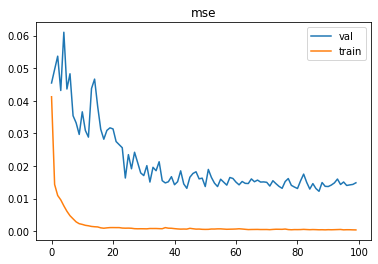

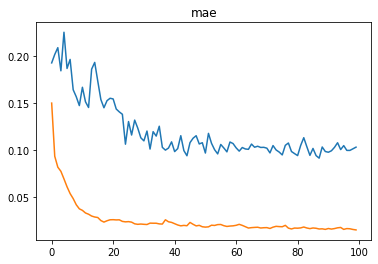

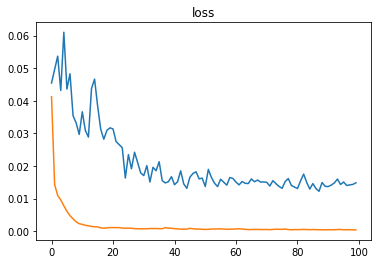

In [11]:
plt.plot(sim_conv_model.history.history['val_mse'], label='val')
plt.plot(sim_conv_model.history.history['mse'], label='train')
plt.title('mse')
plt.legend()
plt.show()

plt.plot(sim_conv_model.history.history['val_mae'])
plt.plot(sim_conv_model.history.history['mae'])
plt.title('mae')
plt.show()

plt.plot(sim_conv_model.history.history['val_loss'])
plt.plot(sim_conv_model.history.history['loss'])
plt.title('loss')
plt.show()

In [14]:
def conv_model_02():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) +1, 
                        512, input_length=MAX_SEQ_LENGTH)) # the number is the output dimension
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu'))
    
    # output layer
    model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
    
    return model

sim_conv_model = conv_model_02()

sim_conv_model.compile(loss='mean_squared_error', 
                       optimizer='adam', 
                       metrics=['mae', 'mse'])
print(sim_conv_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2703, 512)         2560512   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2703, 512)         786944    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 901, 512)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 901, 512)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 901, 256)          393472    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 301, 256)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 301, 256)         

In [15]:
BATCH = 64
EPOCH = 10

sim_conv_model.fit(data_train_sequences[:-100], target_train[:-100], 
                   epochs=EPOCH, batch_size=BATCH, verbose=1, 
                   validation_data=(data_train_sequences[-100:], target_train[-100:]))

Train on 8757 samples, validate on 100 samples
Epoch 1/10
8757/8757 [==============================] - ETA: 1:09 - loss: 0.5038 - mae: 0.6865 - mse: 0.503 - ETA: 50s - loss: 0.2632 - mae: 0.4043 - mse: 0.263 - ETA: 44s - loss: 1.8347 - mae: 1.0098 - mse: 1.83 - ETA: 41s - loss: 1.4057 - mae: 0.8352 - mse: 1.40 - ETA: 39s - loss: 1.1626 - mae: 0.7494 - mse: 1.16 - ETA: 37s - loss: 1.0361 - mae: 0.7276 - mse: 1.03 - ETA: 36s - loss: 0.9500 - mae: 0.7146 - mse: 0.95 - ETA: 35s - loss: 0.8982 - mae: 0.7146 - mse: 0.89 - ETA: 34s - loss: 0.8519 - mae: 0.7105 - mse: 0.85 - ETA: 34s - loss: 0.8127 - mae: 0.7056 - mse: 0.81 - ETA: 33s - loss: 0.7709 - mae: 0.6927 - mse: 0.77 - ETA: 33s - loss: 0.7281 - mae: 0.6741 - mse: 0.72 - ETA: 32s - loss: 0.6847 - mae: 0.6515 - mse: 0.68 - ETA: 32s - loss: 0.6389 - mae: 0.6181 - mse: 0.63 - ETA: 31s - loss: 0.6038 - mae: 0.5960 - mse: 0.60 - ETA: 31s - loss: 0.5733 - mae: 0.5783 - mse: 0.57 - ETA: 30s - loss: 0.5443 - mae: 0.5591 - mse: 0.54 - ETA: 30s -

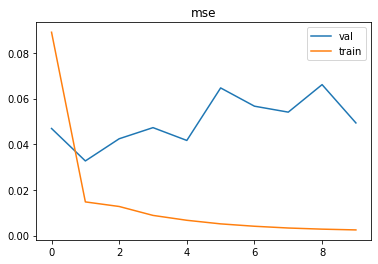

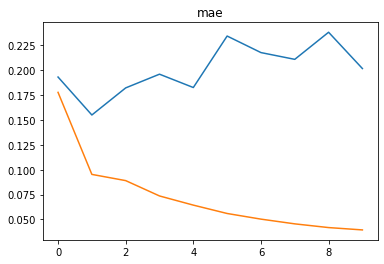

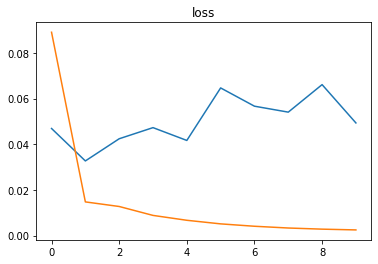

In [16]:
plt.plot(sim_conv_model.history.history['val_mse'], label='val')
plt.plot(sim_conv_model.history.history['mse'], label='train')
plt.title('mse')
plt.legend()
plt.show()

plt.plot(sim_conv_model.history.history['val_mae'])
plt.plot(sim_conv_model.history.history['mae'])
plt.title('mae')
plt.show()

plt.plot(sim_conv_model.history.history['val_loss'])
plt.plot(sim_conv_model.history.history['loss'])
plt.title('loss')
plt.show()

In [20]:
def conv_model_03():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) +1, 
                        64, input_length=MAX_SEQ_LENGTH)) # the number is the output dimension
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu'))
    
    # output layer
    model.add(Dense(units=1, kernel_initializer='normal'))
    
    return model

sim_conv_model = conv_model_03()

sim_conv_model.compile(loss='mean_squared_error', 
                       optimizer='adam', 
                       metrics=['mae', 'mse'])
print(sim_conv_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2703, 64)          320064    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2703, 256)         49408     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 901, 256)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 901, 256)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 901, 128)          98432     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 301, 128)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 301, 128)         

In [21]:
BATCH = 64
EPOCH = 100

sim_conv_model.fit(data_train_sequences[:-100], target_train[:-100], 
                   epochs=EPOCH, batch_size=BATCH, verbose=0, 
                   validation_data=(data_train_sequences[-100:], target_train[-100:]))

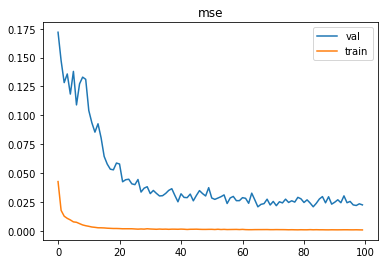

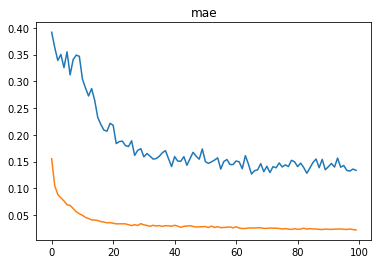

In [22]:
plt.plot(sim_conv_model.history.history['val_mse'], label='val')
plt.plot(sim_conv_model.history.history['mse'], label='train')
plt.title('mse')
plt.legend()
plt.show()

plt.plot(sim_conv_model.history.history['val_mae'])
plt.plot(sim_conv_model.history.history['mae'])
plt.title('mae')
plt.show()

# plt.plot(sim_conv_model.history.history['val_loss'])
# plt.plot(sim_conv_model.history.history['loss'])
# plt.title('loss')
# plt.show()

In [7]:
def conv_model_04():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) +1, 
                        64, input_length=MAX_SEQ_LENGTH)) # the number is the output dimension
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu'))
    
    # output layer
    model.add(Dense(units=1, kernel_initializer='normal'))
    
    return model

sim_conv_model = conv_model_04()

sim_conv_model.compile(loss='mean_squared_error', 
                       optimizer='adam', 
                       metrics=['mae', 'mse'])
print(sim_conv_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2702, 64)          320064    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2702, 512)         98816     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 901, 512)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 901, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 901, 256)          393472    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 301, 256)          0         
______________________________________

In [8]:
BATCH = 64
EPOCH = 100

sim_conv_model.fit(data_train_sequences[:-100], target_train[:-100], 
                   epochs=EPOCH, batch_size=BATCH, verbose=1, 
                   validation_data=(data_train_sequences[-100:], target_train[-100:]))


Train on 8757 samples, validate on 100 samples
Epoch 1/100
8757/8757 [==============================] - ETA: 3:47 - loss: 0.5310 - mae: 0.7121 - mse: 0.531 - ETA: 1:58 - loss: 0.3802 - mae: 0.5840 - mse: 0.380 - ETA: 1:21 - loss: 0.2692 - mae: 0.4454 - mse: 0.269 - ETA: 1:03 - loss: 0.2234 - mae: 0.3943 - mse: 0.223 - ETA: 52s - loss: 0.1856 - mae: 0.3482 - mse: 0.185 - ETA: 45s - loss: 0.1686 - mae: 0.3340 - mse: 0.16 - ETA: 40s - loss: 0.1511 - mae: 0.3129 - mse: 0.15 - ETA: 36s - loss: 0.1352 - mae: 0.2898 - mse: 0.13 - ETA: 33s - loss: 0.1247 - mae: 0.2745 - mse: 0.12 - ETA: 30s - loss: 0.1174 - mae: 0.2645 - mse: 0.11 - ETA: 28s - loss: 0.1085 - mae: 0.2504 - mse: 0.10 - ETA: 26s - loss: 0.1020 - mae: 0.2423 - mse: 0.10 - ETA: 25s - loss: 0.0970 - mae: 0.2369 - mse: 0.09 - ETA: 24s - loss: 0.0932 - mae: 0.2327 - mse: 0.09 - ETA: 23s - loss: 0.0887 - mae: 0.2261 - mse: 0.08 - ETA: 22s - loss: 0.0845 - mae: 0.2187 - mse: 0.08 - ETA: 21s - loss: 0.0822 - mae: 0.2150 - mse: 0.08 - ET

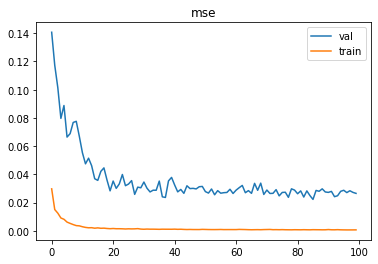

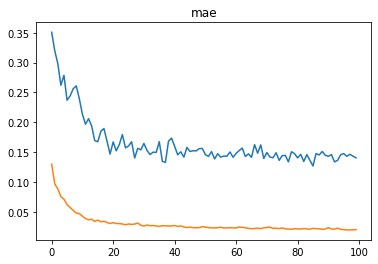

In [9]:
plt.plot(sim_conv_model.history.history['val_mse'], label='val')
plt.plot(sim_conv_model.history.history['mse'], label='train')
plt.title('mse')
plt.legend()
plt.show()

plt.plot(sim_conv_model.history.history['val_mae'])
plt.plot(sim_conv_model.history.history['mae'])
plt.title('mae')
plt.show()


Let's create a function to automatically go through a bunch of parameters, and train several different models, record the results, and plot all of it. Creating each one is tedious, and wastes a bunch of time.

~Though, at this point, I should probably just choose a model, evaluate it on my real data, and see how it compares, as guessing a score is not producing a good mse, so it might just be time to move onto the next task and continue progress on the presentation.~  

# I hadn't properly scaled my scores! 

In [10]:
model_predictions = sim_conv_model.predict(data_valid_sequences)

In [18]:
loc = 3
print(target_validation[loc], model_predictions[loc])
print(mean_squared_error(y_true=target_validation, y_pred=model_predictions))
print(mean_absolute_error(y_true=target_validation, y_pred=model_predictions))

0.78 [0.59847295]
0.024626620511197884
0.13660825376639787


In [ ]:
def conv_model_05():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) +1, 
                        64, input_length=MAX_SEQ_LENGTH)) # the number is the output dimension
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu'))
    
    # output layer
    model.add(Dense(units=1, kernel_initializer='normal'))
    
    return model

sim_conv_model = conv_model_04()

sim_conv_model.compile(loss='mean_squared_error', 
                       optimizer='adam', 
                       metrics=['mae', 'mse'])
print(sim_conv_model.summary())

In [7]:
def cnn_nlp_layer_unit(model, conv_units, kernel_size, pool_size, dropout, regularizer):
    
    model.add(Conv1D(filters=conv_units, kernel_size=kernel_size, 
                     activation='relu', padding='same', kernel_regularizer=regularizer))
    model.add(MaxPooling1D(pool_size=pool_size, padding='same'))
    model.add(Dropout(dropout))
    
    return model

In [8]:
def cnn_nlp_model_blueprint(conv_units, kernel_size, pool_size, 
                            dropout, initial_output=64, regularizer=None):
    
    model = Sequential()
    
    num_layers = len(conv_units)
    
    model.add(Embedding(len(vectorizer.get_feature_names())+1, 
                        output_dim=initial_output, 
                        input_length=MAX_SEQ_LENGTH))
    for i in range(num_layers):
        model = cnn_nlp_layer_unit(model=model, 
                                   conv_units=conv_units[i], 
                                   kernel_size=kernel_size, 
                                   pool_size=pool_size, 
                                   dropout=dropout, 
                                   regularizer=regularizer)
    
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu'))
    
    # output layer
    model.add(Dense(units=1, kernel_initializer='normal'))
    
    return model

In [18]:
def build_test_run_models(epochs, batch_size):
    # want to iterate over several models with varying hyperparameters
    
    EPOCH = epochs
    BATCH = batch_size
    
    # define simple parameter space 
    conv_units = [[2**8, 2**7], [2**9, 2**8], [2**5,2**4,2**3]]
    num_models = len(conv_units)
    kernel_sizes = [3, 5, 7]
    pool_sizes = [3, 5]
    dropouts = [0.3, 0.4]
    
    for model_units in conv_units:
        
        for kernel_size in kernel_sizes:
            
            for pool_size in pool_sizes:
                
                for dropout in dropouts:
                    
                    test_model = cnn_nlp_model_blueprint(conv_units=model_units, 
                                                         kernel_size=kernel_size, 
                                                         pool_size=pool_size, 
                                                         dropout=dropout)
        
                    test_model.compile(loss='mse', 
                                       optimizer='adam', 
                                       metrics=['mae', 'mse'])
            
                    print(test_model.summary())
            
                    print('model parameters')
                    print('convolutional units = {}'.format(model_units))
                    print('kernel size = {}'.format(kernel_size))
                    print('pooling size = {}'.format(pool_size) )
                    print('dropout = {}'.format(dropout) )
        
                    test_model.fit(data_train_sequences[:-500], target_train[:-500], 
                                   epochs=EPOCH, batch_size=BATCH, verbose=1, 
                                   validation_data=(data_train_sequences[-500:], target_train[-500:]))
        
                    plt.plot(test_model.history.history['val_mse'], label='val')
                    plt.plot(test_model.history.history['mse'], label='train')
                    plt.title('mse')
                    plt.legend()
                    plt.show()

                    plt.plot(test_model.history.history['val_mae'])
                    plt.plot(test_model.history.history['mae'])
                    plt.title('mae')
                    plt.show()
        
                    # consider saving the model here
        
                    K.clear_session()
    
    return


In [20]:
K.clear_session()
build_test_run_models(epochs=20, batch_size=64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2708, 64)          320064    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2708, 256)         49408     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 903, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 903, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 903, 128)          98432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 301, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 301, 128)         

KeyboardInterrupt: 